In [82]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display
import data.AudioIdentifier
from collections import Counter

import librosa
import librosa.display

import soundfile as sf

from sklearn.externals import joblib

import keras
from keras import models
from keras import layers
from keras.models import Model
from keras.applications import vgg16
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.imagenet_utils import preprocess_input



import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

## Data Exploration and Analysis

In [3]:
files = glob.glob('data/UrbanSound8K/audio/fold1/*')

In [4]:
len(files)

873

In [5]:
labels_key = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(labels_key.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [6]:
samples = [(labels_key[label], [f for f in files if f.split('-')[1] == label][0]) 
           for label in labels_key.keys()]

samples

[('air_conditioner', 'data/UrbanSound8K/audio/fold1/134717-0-0-18.wav'),
 ('car_horn', 'data/UrbanSound8K/audio/fold1/156194-1-0-0.wav'),
 ('jackhammer', 'data/UrbanSound8K/audio/fold1/180937-7-0-2.wav'),
 ('gun_shot', 'data/UrbanSound8K/audio/fold1/46656-6-2-0.wav'),
 ('engine_idling', 'data/UrbanSound8K/audio/fold1/103258-5-0-1.wav'),
 ('drilling', 'data/UrbanSound8K/audio/fold1/71087-4-1-0.wav'),
 ('dog_bark', 'data/UrbanSound8K/audio/fold1/54858-3-0-0.wav'),
 ('siren', 'data/UrbanSound8K/audio/fold1/157867-8-0-28.wav'),
 ('children_playing', 'data/UrbanSound8K/audio/fold1/182800-2-2-0.wav'),
 ('street_music', 'data/UrbanSound8K/audio/fold1/124489-9-0-17.wav')]

In [7]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr

In [8]:
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]

In [9]:
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (88200,)),
 ('car_horn', (5513,)),
 ('jackhammer', (88200,)),
 ('gun_shot', (33013,)),
 ('engine_idling', (88200,)),
 ('drilling', (17640,)),
 ('dog_bark', (88200,)),
 ('siren', (88200,)),
 ('children_playing', (88200,)),
 ('street_music', (88200,))]

In [10]:
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

air_conditioner :


car_horn :


jackhammer :


gun_shot :


engine_idling :


drilling :


dog_bark :


siren :


children_playing :


street_music :


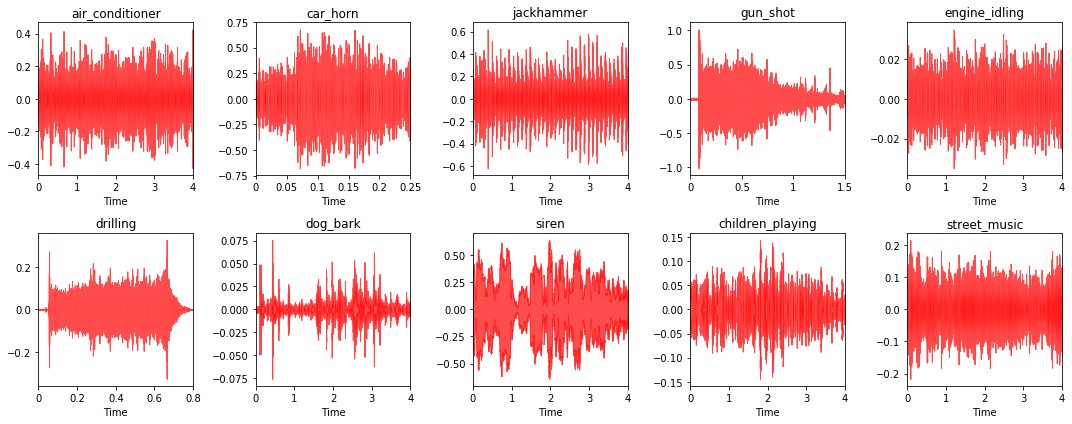

In [11]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

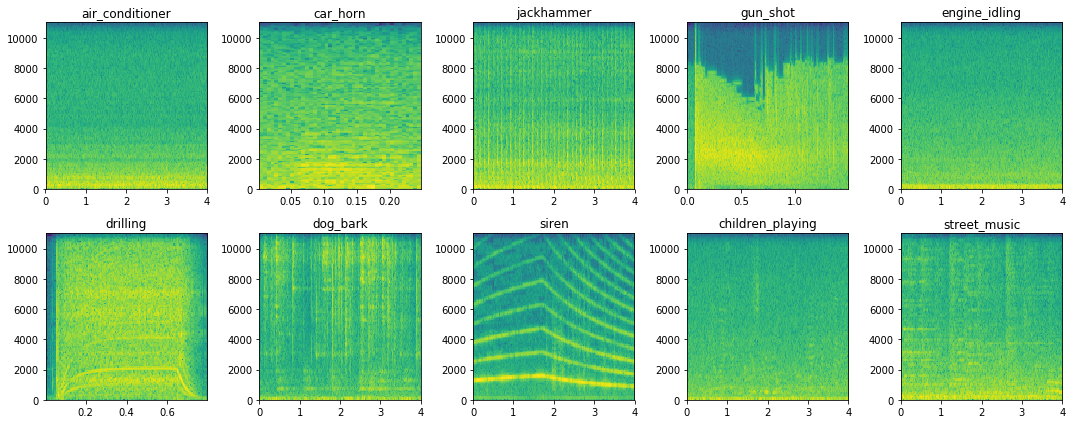

In [12]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

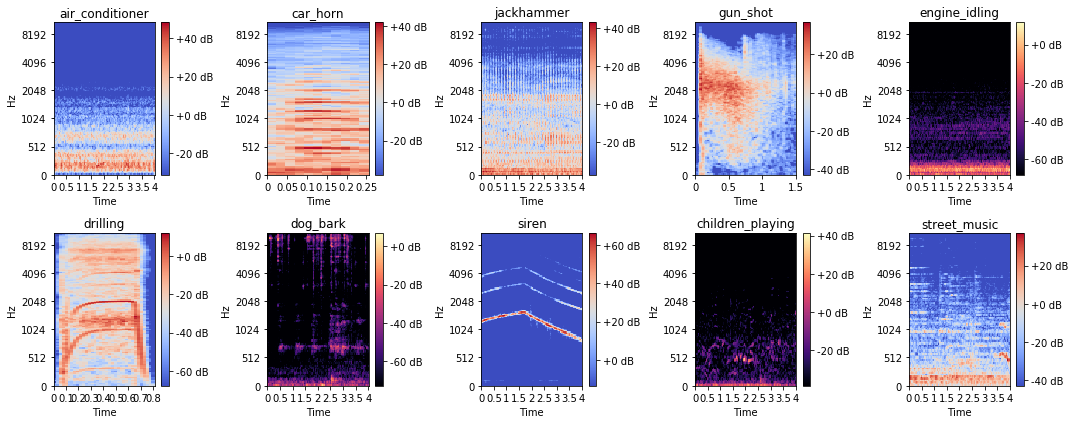

In [13]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    S = librosa.feature.melspectrogram(item[1][0], sr=item[1][1], n_mels=128)
    log_S = librosa.amplitude_to_db(S)
    librosa.display.specshow(log_S, sr=item[1][1], x_axis='time', y_axis='mel')
    plt.title(item[0])
    plt.colorbar(format='%+02.0f dB')
    i += 1
plt.tight_layout()

In [14]:
y = sample_data[6][1][0]

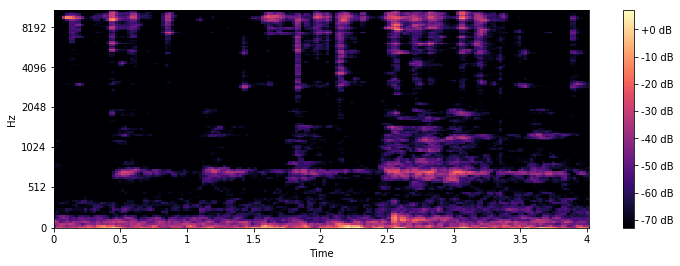

In [15]:
S = librosa.feature.melspectrogram(y, sr=22050, n_mels=128)
log_S = librosa.amplitude_to_db(S)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')
plt.show()

In [16]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

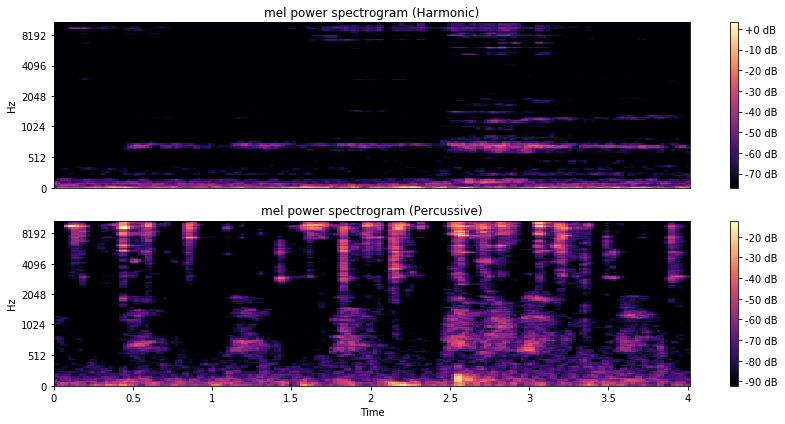

In [17]:
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=22050, n_mels=128)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=22050)
log_Sh = librosa.amplitude_to_db(S_harmonic)
log_Sp = librosa.amplitude_to_db(S_percussive)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
librosa.display.specshow(log_Sh, sr=22050, y_axis='mel')
plt.title('mel power spectrogram (Harmonic)')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=22050, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram (Percussive)')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## Feature Extract Engineering

In [18]:
files[0].split('\\')[-1].split('-')[1]

'7'

In [19]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_resample = librosa.resample(data.T, fsr, sr)
    if len(data_resample.shape) > 1:
        data_resample = np.average(data_resample, axis=0)
    return data_resample, sr

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [20]:
d, sr = get_sound_data(files[0])

In [21]:
len(d), sr

(88200, 22050)

In [22]:
list(windows(d, window_size=512*63))

[(0, 32256),
 (16128, 48384),
 (32256, 64512),
 (48384, 80640),
 (64512, 96768),
 (80640, 112896)]

In [23]:
def extract_features(file_names, bands=64, frames=64):
    
    window_size = 512 * (frames - 1)  
    log_specgrams_full = []
    log_specgrams_hp = []
    class_labels = []

    for fn in file_names:
        file_name = fn.split('\\')[-1]
        class_label = file_name.split('-')[1]
        sound_data, sr = get_sound_data(fn, sr=22050)

        for (start,end) in windows(sound_data, window_size):
            if(len(sound_data[start:end]) == window_size):
                signal = sound_data[start:end]
                melspec_full = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec_full = librosa.amplitude_to_db(melspec_full)
                logspec_full = logspec_full.T.flatten()[:, np.newaxis].T
                y_harmonic, y_percussive = librosa.effects.hpss(signal)
                melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = bands)
                melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = bands)
                logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
                logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
                logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
                logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
                logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)
                
                log_specgrams_full.append(logspec_full)
                log_specgrams_hp.append(logspec_hp)
                class_labels.append(class_label)
              
    log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
    log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
    features = np.concatenate((log_specgrams_full, 
                               log_specgrams_hp, 
                               np.zeros(np.shape(log_specgrams_full))), 
                              axis=3)
 
    for i in range(len(features)):
        features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(class_labels, dtype = np.int)

features, labels = extract_features(files)


/home/hvyd/anaconda3/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [25]:
features.shape, labels.shape

((3079, 64, 64, 3), (3079,))

In [26]:
Counter(labels)

Counter({0: 397,
         1: 56,
         2: 394,
         3: 291,
         4: 337,
         5: 381,
         6: 38,
         7: 441,
         8: 344,
         9: 400})

In [27]:
labels_key = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
     

categories = list(set(labels))
sample_idxs = [np.where(labels == label_id)[0][0] for label_id in categories]
feature_samples = features[sample_idxs]
feature_samples.shape

(10, 64, 64, 3)

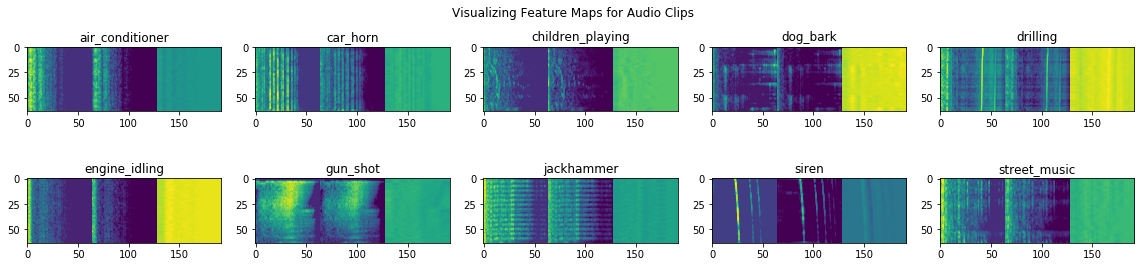

In [28]:
plt.figure(figsize=(16, 4))
for index, (feature_map, category) in enumerate(zip(feature_samples, categories)):
    plt.subplot(2, 5, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(labels_key[str(category)])
plt.tight_layout()
t = plt.suptitle('Visualizing Feature Maps for Audio Clips')

In [29]:
joblib.dump(features, 'base_features.pkl')
joblib.dump(labels, 'dataset_labels.pkl')

['dataset_labels.pkl']

In [30]:
features = joblib.load('base_features.pkl')
labels = joblib.load('dataset_labels.pkl')
features.shape, labels.shape

((3079, 64, 64, 3), (3079,))

In [31]:
data = np.array(list(zip(features, labels)))
data.shape

(3079, 2)

In [32]:
np.random.shuffle(data)

In [33]:
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [34]:
train.shape, validate.shape, test.shape

((1847, 2), (616, 2), (616, 2))

In [35]:
print('Train:', Counter(item[1] for item in train), 
      '\nValidate:', Counter(item[1] for item in validate), 
      '\nTest:',Counter(item[1] for item in test))

Train: Counter({7: 264, 2: 251, 0: 241, 5: 233, 9: 231, 4: 207, 8: 193, 3: 171, 1: 33, 6: 23}) 
Validate: Counter({7: 93, 9: 81, 2: 80, 5: 73, 8: 69, 4: 66, 0: 65, 3: 65, 1: 13, 6: 11}) 
Test: Counter({0: 91, 9: 88, 7: 84, 8: 82, 5: 75, 4: 64, 2: 63, 3: 55, 1: 10, 6: 4})


In [36]:
def process_sound_data(data):
    data = np.expand_dims(data, axis=0)
    data = preprocess_input(data)
    return data

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))


output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

model = Model(vgg.input, output)
model.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [37]:
def extract_tl_features(model, base_feature_data):
    dataset_tl_features = []
    for index, feature_data in enumerate(base_feature_data):
        if (index+1) % 1000 == 0:
            print('Finished processing', index+1, 'sound feature maps')
        pr_data = process_sound_data(feature_data)
        tl_features = model.predict(pr_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        dataset_tl_features.append(tl_features)
    return np.array(dataset_tl_features)

In [38]:
train_base_features = [item[0] for item in train]
train_labels = np.array([item[1] for item in train])
train_tl_features = extract_tl_features(model=model, base_feature_data=train_base_features)

Finished processing 1000 sound feature maps


In [39]:
joblib.dump(train_tl_features, 'train_tl_features.pkl')
joblib.dump(train_labels, 'train_labels.pkl')

['train_labels.pkl']

In [40]:
train_tl_features.shape, train_labels.shape

((1847, 2048), (1847,))

In [41]:
validate_base_features = [item[0] for item in validate]
validate_labels = np.array([item[1] for item in validate])
validate_tl_features = extract_tl_features(model=model, base_feature_data=validate_base_features)

In [42]:
joblib.dump(validate_tl_features, 'validate_tl_features.pkl')
joblib.dump(validate_labels, 'validate_labels.pkl')

['validate_labels.pkl']

In [43]:
test_base_features = [item[0] for item in test]
test_labels = np.array([item[1] for item in test])
test_tl_features = extract_tl_features(model=model, base_feature_data=test_base_features)

In [44]:
joblib.dump(test_tl_features, 'test_tl_features.pkl')
joblib.dump(test_labels, 'test_labels.pkl')

['test_labels.pkl']

In [45]:
train_tl_features.shape, validate_tl_features.shape, test_tl_features.shape

((1847, 2048), (616, 2048), (616, 2048))

## Build and Deploy Model

In [46]:
train_features = joblib.load('train_tl_features.pkl')
train_labels = joblib.load('train_labels.pkl')
validation_features = joblib.load('validate_tl_features.pkl')
validation_labels = joblib.load('validate_labels.pkl')
test_features = joblib.load('test_tl_features.pkl')
test_labels = joblib.load('dataset_labels.pkl')

train_features.shape, validation_features.shape, test_features.shape

((1847, 2048), (616, 2048), (616, 2048))

In [47]:
train_labels.shape, validation_labels.shape, test_labels.shape

((1847,), (616,), (3079,))

In [48]:
train_labels_ohe = to_categorical(train_labels)
validation_labels_ohe = to_categorical(validation_labels)
test_labels_ohe = to_categorical(test_labels)

In [49]:
train_labels_ohe.shape, validation_labels_ohe.shape, test_labels_ohe.shape

((1847, 10), (616, 10), (3079, 10))

In [50]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(train_features.shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_labels_ohe.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

In [51]:
history = model.fit(train_features,
                    train_labels_ohe,
                    epochs=50,
                    batch_size=128,
                    validation_data=(validation_features, validation_labels_ohe), 
                    shuffle=True,
                    verbose=1)

Train on 1847 samples, validate on 616 samples
Epoch 1/50
1847/1847 [==============================] - 4s 2ms/step - loss: 10.7660 - acc: 0.2003 - val_loss: 5.6697 - val_acc: 0.4659
Epoch 2/50
1847/1847 [==============================] - 2s 1ms/step - loss: 7.1423 - acc: 0.3974 - val_loss: 2.2630 - val_acc: 0.7045
Epoch 3/50
1847/1847 [==============================] - 2s 1ms/step - loss: 3.5557 - acc: 0.5782 - val_loss: 1.2067 - val_acc: 0.7484
Epoch 4/50
1847/1847 [==============================] - 2s 1ms/step - loss: 1.9606 - acc: 0.6649 - val_loss: 0.6462 - val_acc: 0.8442
Epoch 5/50
1847/1847 [==============================] - 2s 1ms/step - loss: 1.1176 - acc: 0.7304 - val_loss: 0.5347 - val_acc: 0.8523
Epoch 6/50
1847/1847 [==============================] - 2s 1ms/step - loss: 0.8084 - acc: 0.7807 - val_loss: 0.4959 - val_acc: 0.8588
Epoch 7/50
1847/1847 [==============================] - 2s 1ms/step - loss: 0.6080 - acc: 0.8202 - val_loss: 0.4099 - val_acc: 0.8604
Epoch 8/50
184

In [52]:
predictions = model.predict_classes(test_features)

## Visualize Model

In [54]:
model.save('sound_classification_model.h5')

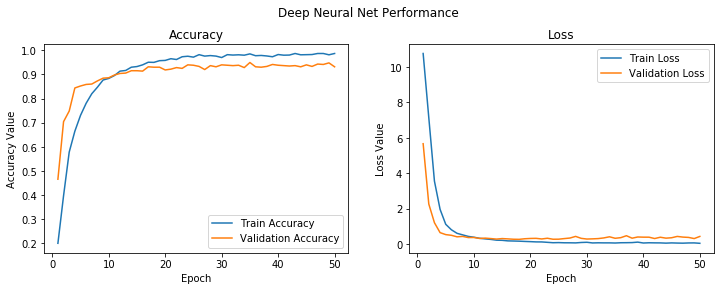

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.2)

epochs = list(range(1,51))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

plt.show()

## Prediction

In [66]:
ai = AudioIdentifier(prediction_model_path='sound_classification_model.h5')

In [67]:
siren_path = 'data/UrbanSound8K/audio/fold1/157867-8-0-28.wav'
gunshot_path = 'data/UrbanSound8K/audio/fold1/46656-6-2-0.wav'
dogbark_path = 'data/UrbanSound8K/audio/fold1/54858-3-0-0.wav'

In [68]:
siren_audio, siren_sr = ai.get_sound_data(siren_path)
gunshot_audio, gunshot_sr = ai.get_sound_data(gunshot_path)
dogbark_audio, dogbark_sr = ai.get_sound_data(dogbark_path)

In [69]:
actual_sounds = ['siren', 'gun_shot', 'dog_bark']
sound_data = [siren_audio, gunshot_audio, dogbark_audio]
sound_rate = [siren_sr, gunshot_sr, dogbark_sr]
sound_paths = [siren_path, gunshot_path, dogbark_path]

In [70]:
for sound_class, data, sr in zip(actual_sounds, sound_data, sound_rate):
    print(sound_class, ':')
    IPython.display.display(IPython.display.Audio(data=data, rate=sr))

siren :


gun_shot :


dog_bark :


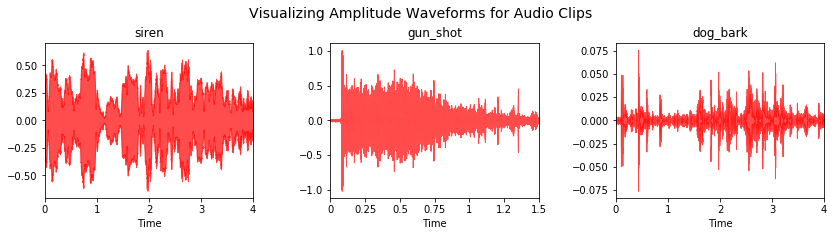

In [71]:
i = 1
fig = plt.figure(figsize=(12, 3.5))
t = plt.suptitle('Visualizing Amplitude Waveforms for Audio Clips', fontsize=14)
fig.subplots_adjust(top=0.8, wspace=0.2)

for sound_class, data, sr in zip(actual_sounds, sound_data, sound_rate):
    plt.subplot(1, 3, i)
    librosa.display.waveplot(data, sr=sr, color='r', alpha=0.7)
    plt.title(sound_class)
    i += 1
plt.tight_layout(pad=2.5)

In [78]:
siren_feature_map = ai.extract_base_features(siren_audio)[0]
gunshot_feature_map = ai.extract_base_features(gunshot_audio)[0]
dogbark_feature_map = ai.extract_base_features(dogbark_audio)[0]
feature_maps = [siren_feature_map, gunshot_feature_map, dogbark_feature_map]

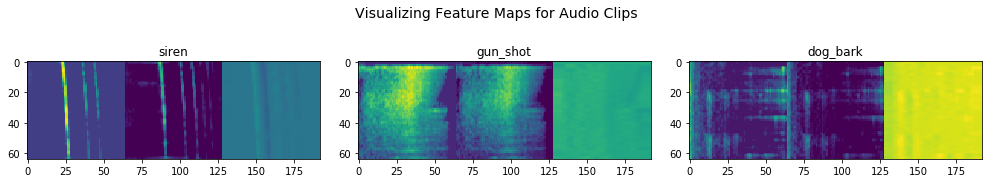

In [79]:
plt.figure(figsize=(14, 3))
t = plt.suptitle('Visualizing Feature Maps for Audio Clips', fontsize=14)
fig.subplots_adjust(top=0.8, wspace=0.1)
for index, (feature_map, category) in enumerate(zip(feature_maps, actual_sounds)):
    plt.subplot(1, 3, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(category)
plt.tight_layout(pad=1.5)

In [80]:
predictions = [ai.prediction_pipeline(audiofile_path, 
                                      return_class_label=True) 
                   for audiofile_path in sound_paths]

In [81]:
result_df = pd.DataFrame({'Actual Sound': actual_sounds,
                          'Predicted Sound': predictions,
                          'Location': sound_paths})
result_df

,Actual Sound,Location,Predicted Sound
0,siren,data/UrbanSound8K/audio/fold1/157867-8-0-28.wav,siren
1,gun_shot,data/UrbanSound8K/audio/fold1/46656-6-2-0.wav,gun_shot
2,dog_bark,data/UrbanSound8K/audio/fold1/54858-3-0-0.wav,dog_bark
